In [ ]:
#Run this to troubleshoot some problem with the cairo library (happens in macos)
#Also, need to add to settings.json the following:
#"terminal.integrated.env.osx": {
#     "DYLD_LIBRARY_PATH": "/opt/homebrew/opt/cairo/lib:${env:DYLD_LIBRARY_PATH}"
# },

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/cairo/lib:$DYLD_LIBRARY_PATH'


In [3]:
import sys
sys.path.append('/Users/evatakou/noise_est')
from color_code_stim import *
from noise_est_funcs_for_color_code import *
from utilities_for_color_code import *
from numerical_equations_for_color_code import *
from defects_matrix_construction import *
from construct_dem import *
import matplotlib.pyplot as plt 
import pymatching 
from pymatching import Matching 


In [ ]:
#W/ PARALLEL PROCESSING

from joblib import Parallel, delayed

def compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots,num_rounds):

    
    obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
    circuit    = obj.circuit
 
    Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
    Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

    dems_stim                     = {}

    for color in ["r", "g", "b"]: 
        dem1,dem2        = obj.get_decomposed_dems(color)
        dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel


    #------- Estimation -------------------------------------
    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)

    min_bound = 1e-12
    max_bound = 0.6 
    method    =  "least_squares" 

    vi_mean_Z      = avg_vi(defects_matrix_Z)
    vivj_mean_Z    = avg_vivj(defects_matrix_Z.data)
    p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
    detector_type  = "Z"
    vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
    sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

    if len(defects_matrix_X)>0: #non-empty

        vi_mean_X      = avg_vi(defects_matrix_X)
        vivj_mean_X    = avg_vivj(defects_matrix_X.data)
        p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds)
        detector_type  = "X"
        vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
        sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


    sols_for_defect_type           = sols_for_Z
    vi_mean                        = vi_mean_Z 
    vivj_mean                      = vivj_mean_Z 
    stims_DEM                      = Z_DEM 
    defects_type                   = "Z"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)

    
    
    error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM)

    if len(defects_matrix_X)>0:

        sols_for_defect_type           = sols_for_X
        vi_mean                        = vi_mean_X 
        vivj_mean                      = vivj_mean_X 
        stims_DEM                      = X_DEM 
        defects_type                   = "X"
        pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
        error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
    else:
        my_X_DEM={}

    r_only_DEM_mine,r_restricted_DEM_mine=create_lattices('r',my_Z_DEM,my_X_DEM,obj)
    b_only_DEM_mine,b_restricted_DEM_mine=create_lattices('b',my_Z_DEM,my_X_DEM,obj)
    g_only_DEM_mine,g_restricted_DEM_mine=create_lattices('g',my_Z_DEM,my_X_DEM,obj)

    dems_mine      = {}
    dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
    dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
    dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

    #Find the detector coordinates and pass them to my dems

    for color in ['r','b','g']:

        for j in range(2):

            temp = dems_stim[color][j]
            
            for instruction in temp:
                if instruction.type=="error":
                    continue 
                else:
                    
                    dems_mine[color][j].append(instruction)

    det, obs  = obj.sample(num_shots)
    preds_obs = obj.decode(det, dems_stim, verbose=False)

    fails_stim = np.logical_xor(obs, preds_obs)
    preds_obs  = obj.decode(det, dems_mine, verbose=False)
    fails_mine = np.logical_xor(obs, preds_obs)


    stims_LE = sum(fails_stim)/num_shots
    my_LE    = sum(fails_mine)/num_shots

    return stims_LE,my_LE



def get_logical_error_rate_vs_QEC_rds(num_shots_for_est, num_shots, d, p, max_round, n_jobs=-1):

    def run_one_round(rd):
        print(f"Running rd: {rd} ...")
        stims_LE, my_LE = compare_logical_error_rate(d, p, num_shots_for_est, num_shots, rd)
        print(f"Done rd: {rd}")
        return stims_LE, my_LE

    results = Parallel(n_jobs=n_jobs)(
        delayed(run_one_round)(rd) for rd in range(1, max_round + 1)
    )

    error_per_round_stim = [res[0] for res in results]
    error_per_round_mine = [res[1] for res in results]

    return error_per_round_stim, error_per_round_mine


num_shots_for_est = 10**6
num_shots         = 10**6
d                 = 5
p                 = 0.001
max_round         = 5

error_per_round_stim,error_per_round_mine = get_logical_error_rate_vs_QEC_rds(num_shots_for_est,num_shots,d,p,max_round)



Running rd: 3 ...Running rd: 2 ...

Running rd: 5 ...
Running rd: 1 ...
Running rd: 4 ...
Done rd: 1
Done rd: 2
Done rd: 3
Done rd: 4
Done rd: 5


([<matplotlib.axis.YTick at 0x1660d2ad0>,
 [Text(0, 0.0001, '$10^{-4}$'),
  Text(0, 0.001, '$10^{-3}$'),
  Text(0, 0.005, '5$\\times 10^{-3}$')])

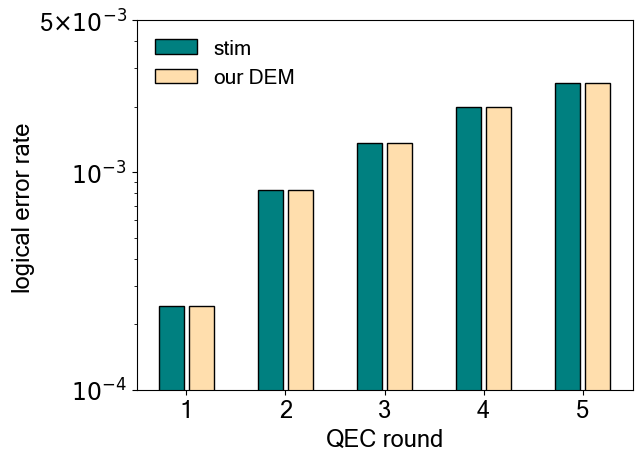

In [10]:
import matplotlib
fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif" 

plt.bar(x=np.arange(1,max_round+1)-0.15,
        height=error_per_round_stim,width=0.25,edgecolor='black',
        facecolor='teal')
plt.bar(x=np.arange(1,max_round+1)+0.15,
        height=error_per_round_mine,width=0.25,edgecolor='black',
        facecolor='navajowhite')


plt.legend(["stim","our DEM"],frameon=False,
                 shadow=True,
                 fontsize=15)
plt.xlabel("QEC round")
plt.ylabel("logical error rate")
plt.yscale('log')

plt.xticks(ticks=np.arange(1,max_round+1)) 
plt.yticks(ticks=[0.0001,0.001,0.005],labels=["$10^{-4}$","$10^{-3}$",r"5$\times 10^{-3}$"])

# fig.savefig("d_7_r_7_error_0.001_N_10_6.pdf",bbox_inches='tight')